In [30]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import enum
from enum import Enum
import os
import librosa
import features, saveDataset
from sklearn import metrics


# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.model_selection import KFold             # 匯入 K 次交叉驗證工具
from sklearn.metrics import accuracy_score            # 匯入準確度計算工具

import warnings
warnings.filterwarnings('ignore')

genre_map = {
    1:'blues',
    2:'classical',
    3:'country',
    4:'disco',
    5:'hiphop',
    6:'jazz',
    7:'metal',
    8:'pop',
    9:'reggae',
    10:'rock',
}


df_column = ['mu_centroid', 'var_centroid',
        'mu_rolloff', 'var_rolloff',
        'mu_flux', 'var_flux',
        'mu_zcr', 'var_zcr',
        'mu_mfcc1', 'var_mfcc1',
        'mu_mfcc2', 'var_mfcc2',
        'mu_mfcc3', 'var_mfcc3',
        'mu_mfcc4', 'var_mfcc4',
        'mu_mfcc5', 'var_mfcc5',
        'mu_mfcc6', 'var_mfcc6',
        'mu_mfcc7', 'var_mfcc7',
        'mu_mfcc8', 'var_mfcc8',
        'mu_mfcc9', 'var_mfcc9',
        'mu_mfcc10', 'var_mfcc10',
        'low_energy',
        'tempo_sum'
        ]

df = pd.read_csv('df_no_index_10mfcc.csv')
df_y = df['genre']
df['genre_name'] = df['genre'].map(genre_map)
df.head()

,mu_centroid,var_centroid,mu_rolloff,var_rolloff,mu_flux,var_flux,mu_zcr,var_zcr,mu_mfcc1,var_mfcc1,...,mu_mfcc8,var_mfcc8,mu_mfcc9,var_mfcc9,mu_mfcc10,var_mfcc10,low_energy,tempo_sum,genre,genre_name
0,1784.165850,129874.508848,3805.839606,9.022032e+05,1.390438,2.195334,0.083045,0.000767,-113.570650,2566.1921,...,15.343150,68.985930,-12.274110,82.267820,10.976572,63.435370,0.530549,75614.095748,1,blues
1,1530.176679,376140.979278,3550.522098,2.980198e+06,1.443493,3.987548,0.056040,0.001448,-207.501700,7770.5650,...,23.370686,142.666290,-10.099661,166.237090,11.900497,104.439384,0.517401,58529.056722,1,blues
2,1552.811865,156588.748355,3042.260232,7.846413e+05,1.637518,3.805839,0.076291,0.001007,-90.722595,3321.6138,...,11.639934,106.657364,-11.783642,65.498604,9.718761,67.961420,0.510441,66971.973001,1,blues
3,1070.106615,184498.632775,2184.745799,1.494350e+06,1.247012,3.063904,0.033309,0.000423,-199.544200,5511.7800,...,9.286495,81.336655,-0.759186,92.185390,8.137607,71.369280,0.549884,55719.181292,1,blues
4,1835.004266,343665.728701,3579.757627,1.574195e+06,1.643324,3.835774,0.101461,0.001954,-160.337700,5199.3130,...,0.498434,124.768620,-11.793437,130.174040,1.207255,99.752750,0.579273,66619.491187,1,blues


In [28]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset_numpy = scaler.fit_transform(df[df_column].to_numpy())
df[df_column] = pd.DataFrame(dataset_numpy, columns=df_column)
df.head()

,mu_centroid,var_centroid,mu_rolloff,var_rolloff,mu_flux,var_flux,mu_zcr,var_zcr,mu_mfcc1,var_mfcc1,...,mu_mfcc8,var_mfcc8,mu_mfcc9,var_mfcc9,mu_mfcc10,var_mfcc10,low_energy,tempo_sum,genre,genre_name
0,0.292922,0.055058,0.361522,0.098111,0.408437,0.112361,0.281738,0.037872,0.732947,0.092360,...,0.597154,0.154135,0.403142,0.231319,0.624931,0.194334,0.515101,0.356878,1,blues
1,0.221026,0.173132,0.326981,0.352494,0.438828,0.206316,0.148516,0.074465,0.554132,0.293355,...,0.741464,0.420937,0.459621,0.575577,0.650005,0.374831,0.486577,0.208131,1,blues
2,0.227433,0.067866,0.258221,0.083719,0.549968,0.196790,0.248421,0.050770,0.776442,0.121535,...,0.530582,0.290546,0.415881,0.162569,0.590794,0.214257,0.471477,0.281637,1,blues
3,0.090795,0.081248,0.142211,0.170600,0.326281,0.157895,0.036378,0.019365,0.569281,0.206120,...,0.488274,0.198858,0.702231,0.271979,0.547883,0.229258,0.557047,0.183667,1,blues
4,0.307313,0.157561,0.330936,0.180374,0.553294,0.198360,0.372588,0.101704,0.643917,0.194052,...,0.330292,0.356128,0.415627,0.427725,0.359798,0.354201,0.620805,0.278568,1,blues


In [21]:
df_x = df[df_column]

train_acc_list = []
test_acc_list = []

# 5 Cross Validation - separate to training set and test set
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)
for train_idx, test_idx in kfold.split(df_x, df_y):
    train_x, test_x = df_x.iloc[train_idx], df_x.iloc[test_idx]
    train_y, test_y = df_y.iloc[train_idx], df_y.iloc[test_idx]

    clf1 = RandomForestClassifier(
        n_estimators=250,
        max_depth=10,
        min_samples_split=2,
        criterion='entropy',
        min_weight_fraction_leaf=0.01,
        random_state=2000)
    model = clf1

    clf2 = SVC(C=70, kernel='rbf', gamma=0.4, random_state=2000)

    # model = clf2

    clf3 = LogisticRegression(
        penalty='l2',
        C=150.0,
        # solver='newton-cg',       # sag 140~145, saga 110~115/135
        max_iter=3000,
        multi_class='multinomial',
        random_state=2000)
    # model = clf3

    model = VotingClassifier(   # 0.786
        estimators=[('rf', clf1), ('svc', clf2), ('lr', clf3)], voting='hard') 

    model.fit(train_x, train_y)
    train_pred_y = model.predict(train_x)
    train_acc = metrics.accuracy_score(train_y, train_pred_y)
    test_pred_y = model.predict(test_x)
    test_acc = metrics.accuracy_score(test_y, test_pred_y)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

print('Average train accuracy: {}\nAverage validate accuracy: {}'.format(
    np.mean(train_acc_list), np.mean(test_acc_list)
))

Average train accuracy: 0.9915
Average validate accuracy: 0.806


array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  8,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  1,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  8,  0],
       [ 2,  0,  2,  0,  1,  0,  0,  0,  1,  4]], dtype=int64)

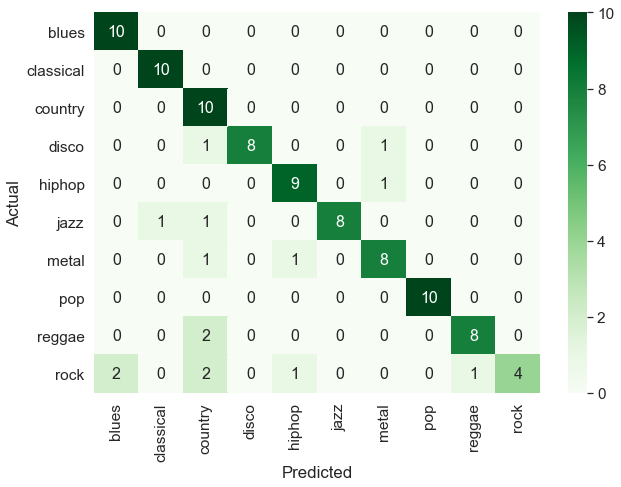

In [27]:
labels = [ 'blues', 'classical', 'country', 
          'disco', 'hiphop', 'jazz', 'metal',
            'pop', 'reggae', 'rock']

confusion_mat = confusion_matrix(test_y, test_pred_y)
confusion_mat = 
df_cm = pd.DataFrame(confusion_mat, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Greens", annot=True,annot_kws={"size": 16})# font size